# Data processing for bump hunt

Main differences for bump hunt:
- No fully supervised set
- test set covers the whole SR / SB range



In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pickle

from helpers.plotting import *
from helpers.physics_functions import *

plt.style.use("../science.mplstyle")


In [2]:
import yaml
with open("workflow.yaml", "r") as file:
    workflow = yaml.safe_load(file)

In [3]:
project_id = "lowmass"
path_to_compiled_data = f"/pscratch/sd/r/rmastand/dimuonAD/compiled_data/{project_id}"

    
if project_id == "lowmass":
    codes_list = ["DATA_nojet"]
    sim_id = "DATA_nojet"
    signal_id = "DATA_nojet"

    
uncut_data, uncut_data_samesign = {code:{} for code in codes_list},  {code:{} for code in codes_list}

for code in codes_list:
    with open(f"{path_to_compiled_data}/{code}", "rb") as ifile:
        tmp_dict = pickle.load(ifile)
        for key in tmp_dict.keys():
            if "samesign" in key:
                uncut_data_samesign[code][key[:-9]] = tmp_dict[key]
            else:
                uncut_data[code][key] = tmp_dict[key]
        
    
    print(code, "opp sign",  uncut_data[code][list(uncut_data[code].keys())[0]].shape)
    print(code, "same sign", uncut_data_samesign[code][list(uncut_data[code].keys())[0]].shape)

DATA_nojet opp sign (21803678,)
DATA_nojet same sign (6756613,)


## Visualize the data

In [4]:
feature_set = list(uncut_data[codes_list[0]].keys())
print(feature_set)

#hist_all_features(codes_list, uncut_data, feature_set, kwargs_dict_dtype, nice_labels=True)
    


['mu0_iso03', 'mu1_iso03', 'mu0_eta', 'mu1_eta', 'mu0_pt', 'mu1_pt', 'mu0_phi', 'mu1_phi', 'mu0_iso04', 'mu1_iso04', 'dimu_pt', 'dimu_eta', 'dimu_phi', 'n_muons', 'n_jets', 'dimu_mass', 'mumu_deltaR', 'mumu_deltapT']


## Make cuts

Now let's define cuts on the data. 

Muon cuts were made previously (and we don't want to make cuts on the dimuon system, either)

Random seed is used to set aside a portion of the test set

In [6]:
particle_type = "eta_shifted"



SB_left = float(workflow[particle_type]["SB_left"])
SR_left = float(workflow[particle_type]["SR_left"])
SR_right = float(workflow[particle_type]["SR_right"])
SB_right = float(workflow[particle_type]["SB_right"])



band_bounds = {"SBL": [SB_left,SR_left],
                   "SR": [SR_left,SR_right],
                   "SBH": [SR_right,SB_right],
                           }

if particle_type == "eta":
    N_test = 32000
    random_seed = 2


elif particle_type == "upsilon":
    N_test = 32000
    random_seed = 6
    
    
else:
    N_test = 32000
    random_seed = 7

plot_bins_SR = np.linspace(SR_left, SR_right, 6)
width = plot_bins_SR[1] - plot_bins_SR[0]


In [7]:
cut_data, cut_data_samesign = {code:{} for code in codes_list},  {code:{} for code in codes_list}

for code in codes_list:
    
    # define cuts to reduce the starting significance
    if "upsilon" in particle_type:
        pass_indices = (uncut_data[code]["mu0_iso04"] > 0.65) & (uncut_data[code]["mu1_iso04"] > 0.65)
        pass_indices_samesign = (uncut_data_samesign[code]["mu0_iso04"] > 0.65) & (uncut_data_samesign[code]["mu1_iso04"] > 0.65)
        
    else:
        # these cuts do nothing
        pass_indices = (uncut_data[code]["mu0_iso04"] > -.5) & (uncut_data[code]["mu1_iso04"] > -.5)
        pass_indices_samesign = (uncut_data_samesign[code]["mu0_iso04"] > -.5) & (uncut_data_samesign[code]["mu1_iso04"] > -.5)
    
    
    # apply cuts to oppsign
    for feat in feature_set:
        cut_data[code][feat] = uncut_data[code][feat][pass_indices]
    # apply cuts to samesign
    for feat in feature_set:
        cut_data_samesign[code][feat] = uncut_data_samesign[code][feat][pass_indices_samesign]
    
    print(f"{code} oppsign has shape {cut_data[code][feat].shape} after cuts")
    print(f"{code} samesign has shape {cut_data_samesign[code][feat].shape} after cuts")
    

DATA_nojet oppsign has shape (21803678,) after cuts
DATA_nojet samesign has shape (6756613,) after cuts


Check how local cuts affect the starting significance

(168925,)


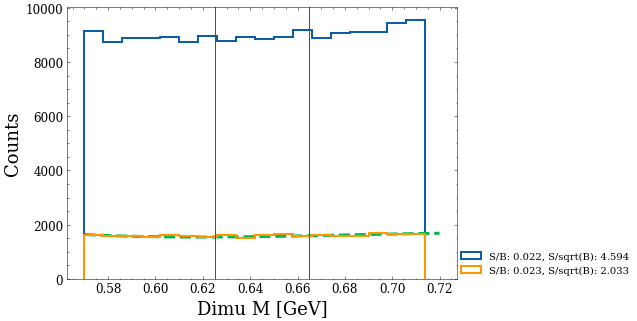

In [8]:
p0  = [5000, -20000, 30000, -10000]

bins = np.arange(SB_left, SB_right, width) # histogram bins
x = np.linspace(SB_left, SB_right, 100) # plot curve fit

masses_with_bounds = cut_data[code]["dimu_mass"][(cut_data[code]["dimu_mass"] >= SB_left) & (cut_data[code]["dimu_mass"] <= SB_right)]
masses_with_bounds_samesign = cut_data_samesign[code]["dimu_mass"][(cut_data_samesign[code]["dimu_mass"] >= SB_left) & (cut_data_samesign[code]["dimu_mass"] <= SB_right)]


plt.figure(figsize = (7,5))

# plot all data
loc_data = masses_with_bounds
print(loc_data.shape)
popt_0, _, _, _, _, _ = curve_fit_m_inv(loc_data, bkg_fit_cubic, SB_left, SB_right, SR_left, SR_right, width, p0)
#plt.plot(x, bkg_fit_cubic(x, *popt_0), lw = 3, linestyle = "dashed")
num_S_expected_in_SR, num_B_expected_in_SR = calc_significance(loc_data, bkg_fit_cubic, plot_bins_SR, SR_left, SR_right, popt_0)

plt.hist(loc_data, bins = bins, lw = 2, histtype = "step", density = False, label = f"S/B: {round(num_S_expected_in_SR/num_B_expected_in_SR,3)}, S/sqrt(B): {round(num_S_expected_in_SR/np.sqrt(num_B_expected_in_SR),3)}")


# plot subset of data
np.random.shuffle(masses_with_bounds)
loc_data = masses_with_bounds[:30000]
popt_0, _, _, _, _, _= curve_fit_m_inv(loc_data, bkg_fit_cubic, SB_left, SB_right, SR_left, SR_right, width, p0)
plt.plot(x, bkg_fit_cubic(x, *popt_0), lw = 3, linestyle = "dashed")
num_S_expected_in_SR, num_B_expected_in_SR = calc_significance(loc_data, bkg_fit_cubic, plot_bins_SR, SR_left, SR_right, popt_0)
plt.hist(loc_data, bins = bins, lw = 2, histtype = "step", density = False, label = f"S/B: {round(num_S_expected_in_SR/num_B_expected_in_SR,3)}, S/sqrt(B): {round(num_S_expected_in_SR/np.sqrt(num_B_expected_in_SR),3)}")


plt.axvline(SR_left)
plt.axvline(SR_right)

plt.xlabel("Dimu M [GeV]")
plt.ylabel("Counts")
plt.legend(loc = (1, 0))


plt.show()
 
    
#hist_all_features(codes_list, cut_data, feature_set, kwargs_dict_dtype)


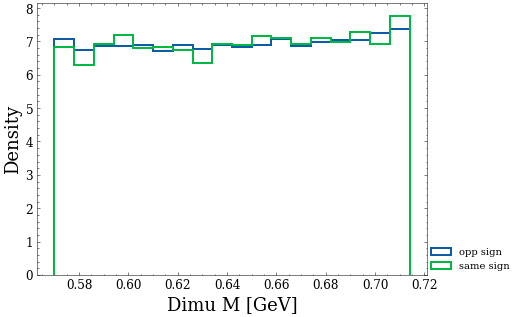

In [9]:

plt.figure(figsize = (7,5))

# plot all data
loc_data = masses_with_bounds
plt.hist(loc_data, bins = bins, lw = 2, histtype = "step", density = True, label = f"opp sign")
plt.hist(masses_with_bounds_samesign, bins = bins, lw = 2, histtype = "step", density = True, label = f"same sign")


plt.xlabel("Dimu M [GeV]")
plt.ylabel("Density")
plt.legend(loc = (1, 0))


plt.show()
 
    
#hist_all_features(codes_list, cut_data, feature_set, kwargs_dict_dtype)


Split data into bands

In [10]:
bands = ["SBL", "SR", "SBH"]
N_total_events = 0

sizes_dict = {}

preproc_dicts, preproc_dicts_samesign = {b:{} for b in bands}, {b:{} for b in bands}


for code in codes_list:
    for b in bands:

        # opp sign
        loc_pass_indices = (cut_data[code]["dimu_mass"] >= band_bounds[b][0]) & (cut_data[code]["dimu_mass"] < band_bounds[b][1])
        preproc_dicts[b][code] = {}
        for feat in feature_set:
            preproc_dicts[b][code][feat] = cut_data[code][feat][loc_pass_indices]
            
        sizes_dict[b] = preproc_dicts[b][code][feat].shape[0]
        N_total_events += preproc_dicts[b][code][feat].shape[0]
        
        # same sign
        loc_pass_indices_samesign = (cut_data_samesign[code]["dimu_mass"] >= band_bounds[b][0]) & (cut_data_samesign[code]["dimu_mass"] < band_bounds[b][1])
        preproc_dicts_samesign[b][code] = {}
        for feat in feature_set:
            preproc_dicts_samesign[b][code][feat] = cut_data_samesign[code][feat][loc_pass_indices_samesign]
  
    
    
print(f"Total events: {N_total_events}")
    

Total events: 168925


In [11]:
print(sizes_dict)

{'SBL': 60911, 'SR': 44877, 'SBH': 63137}


## Preprocessing

Standard scaling is fine

In [12]:
from sklearn.preprocessing import StandardScaler

proccessed_data_dict, proccessed_data_dict_samesign  = {b:{"s_inj_data":{}} for b in bands}, {b:{"s_inj_data":{}} for b in bands}


for feat in feature_set: 
    
    # train the preprocessor on the opp sign data only
    SB_all = np.hstack((preproc_dicts["SBL"][sim_id][feat], preproc_dicts["SBH"][sim_id][feat])).reshape(-1, 1)
    loc_feat_scaler = StandardScaler()
    loc_feat_scaler = loc_feat_scaler.fit(SB_all)
    
    if feat == "dimu_mass":
        with open(f"processed_data/mass_scaler_{particle_type}", "wb") as ofile:
            pickle.dump(loc_feat_scaler, ofile)
            mass_scaler = loc_feat_scaler

    
    for b in bands:
        proccessed_data_dict[b]["s_inj_data"][feat] = loc_feat_scaler.transform(preproc_dicts[b][sim_id][feat].reshape(-1, 1))
        proccessed_data_dict_samesign[b]["s_inj_data"][feat] = loc_feat_scaler.transform(preproc_dicts_samesign[b][sim_id][feat].reshape(-1, 1))
        
        # extra preprocessing to get centers closer to zero
        if ("pt" in feat) or ("iso" in feat) or ("jet_mass" in feat) or ("deltapT" in feat):
            proccessed_data_dict[b]["s_inj_data"][feat] = (proccessed_data_dict[b]["s_inj_data"][feat]-10)/4
            proccessed_data_dict_samesign[b]["s_inj_data"][feat] = (proccessed_data_dict_samesign[b]["s_inj_data"][feat]-10)/4
        if particle_type == "eta":
            if ("mumu_deltaR" in feat):
                proccessed_data_dict[b]["s_inj_data"][feat] = (proccessed_data_dict[b]["s_inj_data"][feat]-2)/2
                proccessed_data_dict_samesign[b]["s_inj_data"][feat] = (proccessed_data_dict_samesign[b]["s_inj_data"][feat]-2)/2

            



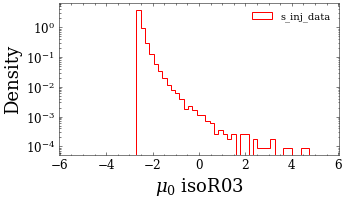

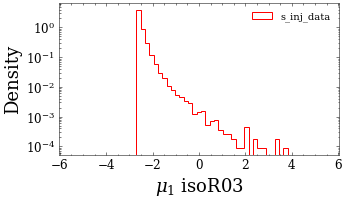

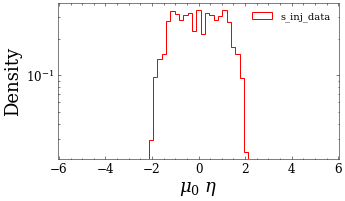

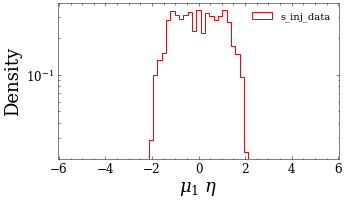

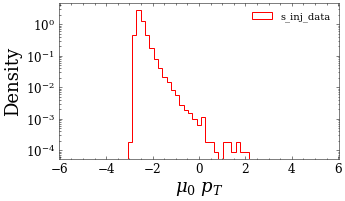

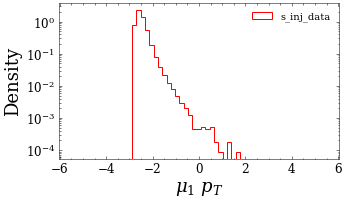

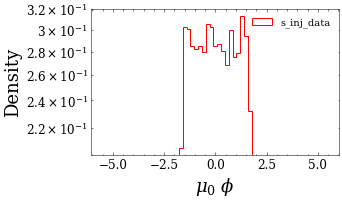

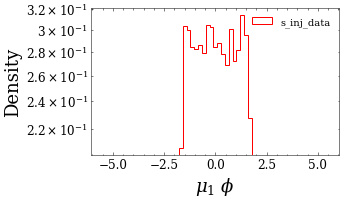

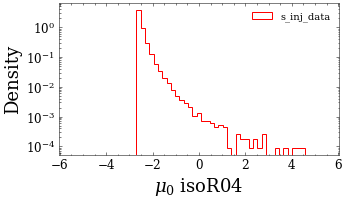

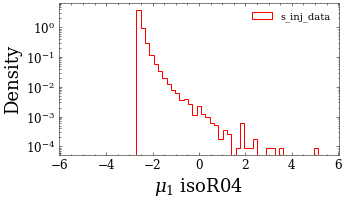

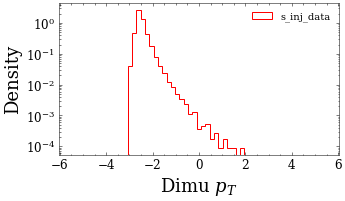

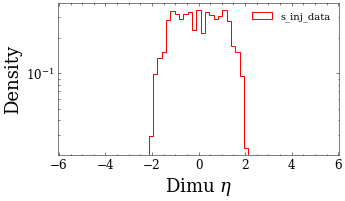

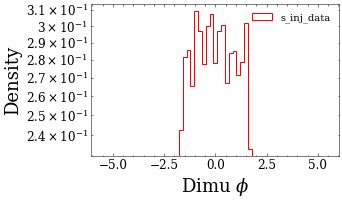

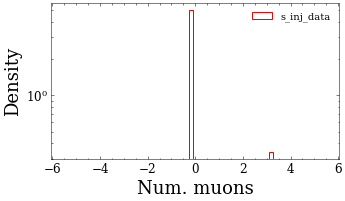

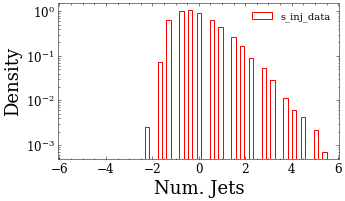

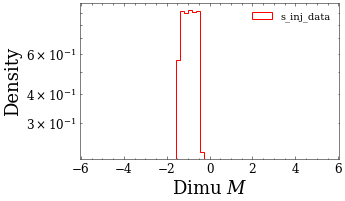

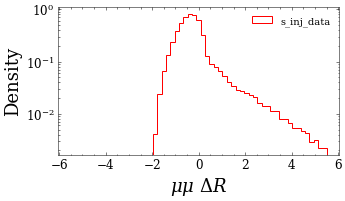

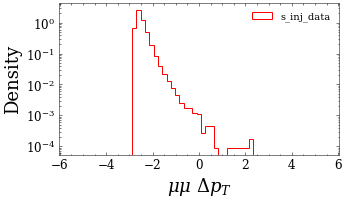

In [13]:
hist_all_features(["s_inj_data"], proccessed_data_dict["SBL"], feature_set, kwargs_dict_dtype, 
                  scaled_features = True, plot_bound = 5.5, yscale_log = True, nice_labels = True)


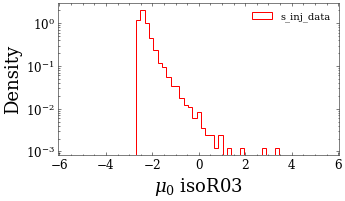

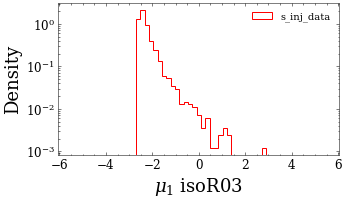

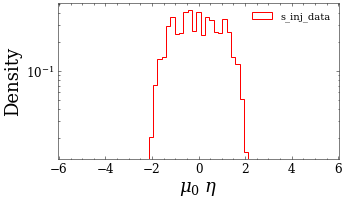

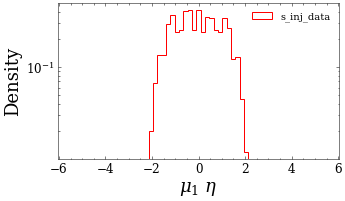

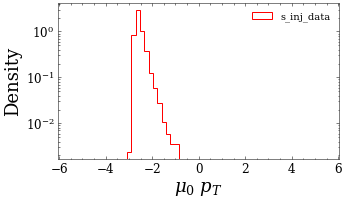

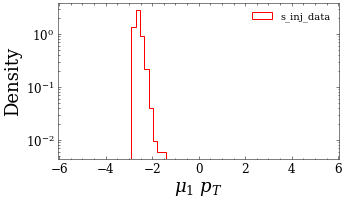

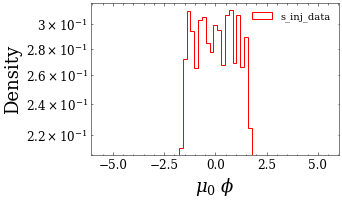

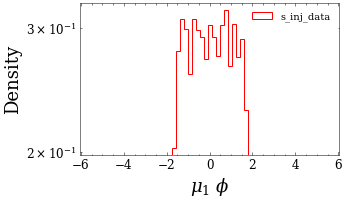

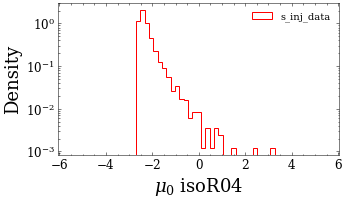

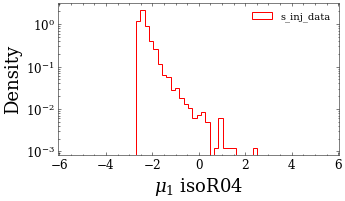

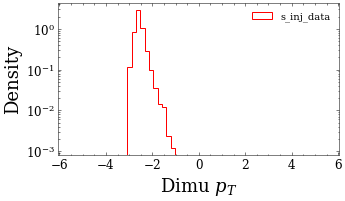

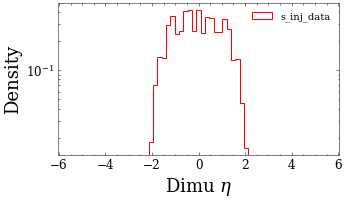

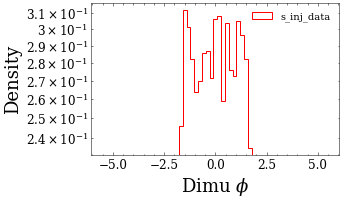

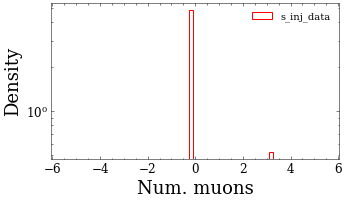

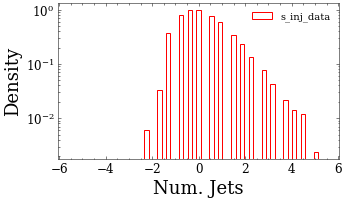

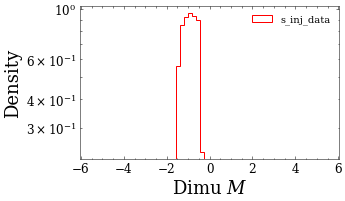

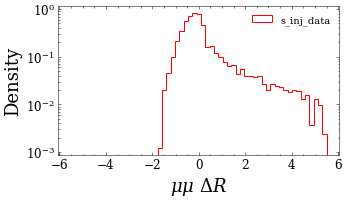

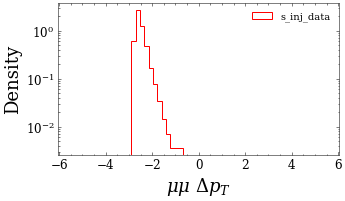

In [14]:
hist_all_features(["s_inj_data"], proccessed_data_dict_samesign["SBL"], feature_set, kwargs_dict_dtype, 
                  scaled_features = True, plot_bound = 5.5, yscale_log = True, nice_labels = True)


In [15]:
# specify a percentage of events to set aside for the test set


train_data_dict = {b:{"s_inj_data":{}} for b in bands}
test_data_dict = {b:{"s_inj_data":{}} for b in bands}


x = 0

for b in bands:
    
    # get indices to select
    loc_num_test_events = int((N_test/N_total_events)*sizes_dict[b])
    x += loc_num_test_events
    
    np.random.seed(random_seed)
    test_set_inds = np.random.choice(range(sizes_dict[b]), size = loc_num_test_events, replace = False)
    train_set_inds = np.setdiff1d(list(range(sizes_dict[b])),test_set_inds)
        
    for feat in feature_set:
        
        train_data_dict[b]["s_inj_data"][feat] = proccessed_data_dict[b]["s_inj_data"][feat][train_set_inds]
        test_data_dict[b]["s_inj_data"][feat] = proccessed_data_dict[b]["s_inj_data"][feat][test_set_inds]


test_set_size = test_data_dict["SR"]["s_inj_data"]["dimu_mass"].shape[0] + test_data_dict["SBL"]["s_inj_data"]["dimu_mass"].shape[0]+ test_data_dict["SBH"]["s_inj_data"]["dimu_mass"].shape[0]
train_set_size = train_data_dict["SR"]["s_inj_data"]["dimu_mass"].shape[0] + train_data_dict["SBL"]["s_inj_data"]["dimu_mass"].shape[0]+ train_data_dict["SBH"]["s_inj_data"]["dimu_mass"].shape[0]
ss_set_size = proccessed_data_dict_samesign["SR"]["s_inj_data"]["dimu_mass"].shape[0] + proccessed_data_dict_samesign["SBL"]["s_inj_data"]["dimu_mass"].shape[0]+ proccessed_data_dict_samesign["SBH"]["s_inj_data"]["dimu_mass"].shape[0]


print(f"{test_set_size} test events (target: {N_test}). {train_set_size} train events")      
print(f"{ss_set_size} samesign events")      



31999 test events (target: 32000). 136926 train events
12457 samesign events


In [16]:
## trial_train_set = mass_scaler.inverse_transform(np.concatenate((train_data_dict["SBL"]["s_inj_data"]["dimu_mass"], train_data_dict["SBH"]["s_inj_data"]["dimu_mass"], train_data_dict["SR"]["s_inj_data"]["dimu_mass"])))
trial_test_set = mass_scaler.inverse_transform(np.concatenate((test_data_dict["SBL"]["s_inj_data"]["dimu_mass"], test_data_dict["SBH"]["s_inj_data"]["dimu_mass"], test_data_dict["SR"]["s_inj_data"]["dimu_mass"])))

Check starting significances

(31999, 1)
174.29739870727644 8326.702601292724


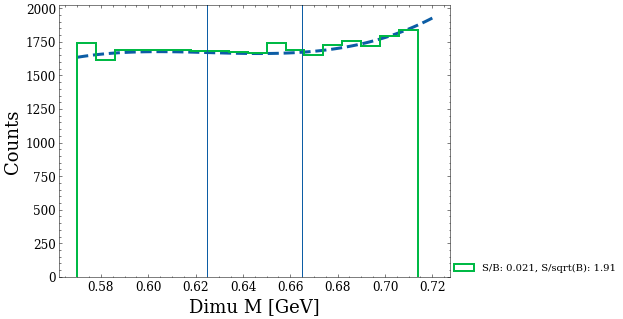

In [17]:
p0  = [5000, -20000, 30000, -10000]

plt.figure(figsize = (7,5))

bins = np.arange(SB_left, SB_right, width)
x = np.linspace(SB_left, SB_right, 100)



print(trial_test_set.shape)
popt_0, _, _, _, _, _ = curve_fit_m_inv(trial_test_set, bkg_fit_cubic, SB_left, SB_right, SR_left, SR_right, width, p0)
plt.plot(x, bkg_fit_cubic(x, *popt_0), lw = 3, linestyle = "dashed")
num_S_expected_in_SR, num_B_expected_in_SR = calc_significance(trial_test_set, bkg_fit_cubic, plot_bins_SR, SR_left, SR_right, popt_0)

print(num_S_expected_in_SR, num_B_expected_in_SR)

plt.hist(trial_test_set, bins = bins, lw = 2, histtype = "step", density = False, label = f"S/B: {round(num_S_expected_in_SR/num_B_expected_in_SR,3)}, S/sqrt(B): {round(num_S_expected_in_SR/np.sqrt(num_B_expected_in_SR),3)}")

plt.xlabel("Dimu M [GeV]")
plt.ylabel("Counts")
plt.legend(loc = (1, 0))

plt.axvline(SR_left)
plt.axvline(SR_right)

plt.show()
 
    

In [18]:
with open(f"processed_data/{project_id}_{particle_type}_nojet_train_band_data", "wb") as ofile:
    pickle.dump(train_data_dict, ofile)
        
        
with open(f"processed_data/{project_id}_{particle_type}_nojet_test_band_data", "wb") as ofile:
    pickle.dump(test_data_dict, ofile)
    
    
with open(f"processed_data/{project_id}_{particle_type}_nojet_samesign_band_data", "wb") as ofile:
    pickle.dump(proccessed_data_dict_samesign, ofile)